In [1]:
!wget -O CoFly-WeedDB.zip 'https://zenodo.org/record/6697343/files/CoFly-WeedDB.zip?download=1'

--2025-08-12 06:30:59--  https://zenodo.org/record/6697343/files/CoFly-WeedDB.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/6697343/files/CoFly-WeedDB.zip [following]
--2025-08-12 06:31:00--  https://zenodo.org/records/6697343/files/CoFly-WeedDB.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1198780322 (1.1G) [application/octet-stream]
Saving to: ‘CoFly-WeedDB.zip’

CoFly-WeedDB.zip    100%[===================>]   1.12G  15.6MB/s    in 77s     

2025-08-12 06:32:17 (14.8 MB/s) - ‘CoFly-WeedDB.zip’ saved [1198780322/1198780322]



In [2]:
%%capture
!unzip CoFly-WeedDB.zip
!pip install tensorflow scikit-learn scikit-image patchify albumentations segmentation-models tqdm

In [3]:
import numpy as np
import os
import tqdm as tqdm

from skimage.io import imread
from patchify import patchify
from skimage import io as skio
import math

import albumentations as A

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

2025-08-12 06:33:01.967381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754980382.170178      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754980382.229910      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


## Step 1: Augmentation Class
This class, taken from augment.py, defines the image augmentation pipeline using the albumentations library. It sets up two separate transformation sequences (transform1 and transform2) that will be applied to each training image and its corresponding mask to create new, varied training samples.

In [4]:
class Augment:

    def __init__(self, X_train, Y_train):
        self.transform1 = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=1.0),
            A.GridDistortion(p=1.0)
        ])
        self.transform2 = A.Compose([
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=1.0),
            A.GridDistortion(p=1.0)
        ])
        self.X_train = X_train
        self.Y_train = Y_train

    def augment(self):
        # Create empty lists to store augmented images and masks
        augmented_images = []
        augmented_masks = []

        # Iterate over the images and masks arrays
        for i in range(len(self.X_train)):
            image = self.X_train[i]
            mask = self.Y_train[i]

            # Apply augmentation transformations to the image and mask
            augmented = self.transform1(image=image, mask=mask)
            augmented_image = augmented['image']
            augmented_mask = augmented['mask']

            # Append the augmented image and mask to the lists
            augmented_images.append(augmented_image)
            augmented_images.append(image)
            augmented_masks.append(augmented_mask)
            augmented_masks.append(mask)
            # Second agumentation
            augmented = self.transform2(image=image, mask=mask)
            augmented_image = augmented['image']
            augmented_mask = augmented['mask']

            augmented_images.append(augmented_image)
            augmented_masks.append(augmented_mask)
        # Convert the augmented image and mask lists to NumPy arrays
        augmented_images = np.array(augmented_images)
        augmented_masks = np.array(augmented_masks)

        # Print the shape of the augmented image and mask arrays
        print("Augmented Images shape:", augmented_images.shape)
        print("Augmented Masks shape:", augmented_masks.shape)
        return augmented_images, augmented_masks

## Step 2: Patch Generation Class
This class, from create_patch.py, handles the core logic of patchifying the images. It takes a list of large images and masks, pads them to be perfectly divisible by the patch size, and then uses the patchify library to extract non-overlapping patches. It includes a crucial filtering step to only keep patches that contain a meaningful amount of weed pixels, controlled by the threshold.

In [5]:
class Patches:

    def __init__(self, im_list, msk_list, PATCH_SIZE, threshold=0.03):
        self.im_list = im_list
        self.msk_list = msk_list
        self.PATCH_SIZE = PATCH_SIZE
        self.threshold = threshold

    def image_to_patches(self, image, b_msk=False):
        slc_size = self.PATCH_SIZE
        x = int(math.ceil(int(image.shape[0]) / (slc_size * 1.0)))
        y = int(math.ceil(int(image.shape[1]) / (slc_size * 1.0)))
        padded_shape = (x * slc_size, y * slc_size)
        if not b_msk:
            padded_rgb_image = np.zeros((padded_shape[0], padded_shape[1], 3), dtype=np.uint8)
            padded_rgb_image[:image.shape[0], :image.shape[1]] = image
            patches = patchify(padded_rgb_image, (slc_size, slc_size, 3), step=slc_size)
        elif b_msk:
            padded_rgb_image = np.zeros((padded_shape[0], padded_shape[1]), dtype=np.uint8)
            padded_rgb_image[:image.shape[0], :image.shape[1]] = image
            patches = patchify(padded_rgb_image, (slc_size, slc_size), step=slc_size)

        return patches, slc_size

    def load_image(self, path):
        """
        loads an image based on the path
        """
        rgb_image = skio.imread(path)
        return rgb_image

    def patchify_image_mask(self):
        imgs = []
        anns = []
        AREA = self.PATCH_SIZE * self.PATCH_SIZE
        f_AREA = int(self.threshold * AREA)
        print(f'Threshold: {self.threshold} * {AREA} = {f_AREA} pixels')
        print(f"Patchifying images and masks...")
        
        # Use tqdm for a progress bar
        for im_path, msk_path in tqdm.tqdm(zip(self.im_list, self.msk_list), total=len(self.im_list)):
            patches, _ = self.image_to_patches(self.load_image(im_path))
            masks, _ = self.image_to_patches(self.load_image(msk_path), b_msk=True)
            for i in range(patches.shape[0]):
                for j in range(patches.shape[1]):
                    # The original code had a shape mismatch issue here. Corrected.
                    patch = patches[i, j, 0, :, :, :]
                    mask = masks[i, j, :, :]
                    # Keep patches where the sum of mask pixels is above the threshold
                    if mask.sum() > f_AREA:
                        imgs.append(patch)
                        anns.append(mask)
        return np.array(imgs), np.array(anns)

## Step 3: Main Dataset Preparation Class
This is the orchestrator class from prepare_dataset.py. It brings everything together. The prepare_all method executes the entire pipeline from start to finish.

In [6]:
class Prepare_Dataset:
    def __init__(self, PATCH_SIZE, threshold=0.03, backbone='None',
                 train_split_file='./CoFly-WeedDB/train_split1.txt',
                 test_split_file='./CoFly-WeedDB/test_split1.txt', IMG_CHANNELS=3,
                 test_size=0.2, data_path='./CoFly-WeedDB'):
        self.train_split_file = train_split_file
        self.test_split_file = test_split_file
        self.PATCH_SIZE = PATCH_SIZE
        self.IMG_CHANNELS = IMG_CHANNELS
        self.test_size = test_size
        self.backbone = backbone
        self.data_path = data_path
        self.threshold = threshold

    def read_files(self, train_split_file, test_split_file):
        train_ids = []
        test_ids = []
        with open(train_split_file, 'r') as f:
            for line in f:
                train_ids.append(line.strip())

        with open(test_split_file, 'r') as f:
            for line in f:
                test_ids.append(line.strip())
        return train_ids, test_ids

    def convert_image_id_to_path(self, total_ids, path):
        img_lst = []
        msk_lst = []
        for itm in total_ids:
            image_path = os.path.join(path, 'images', itm)
            img_lst.append(image_path)
            mask_path = os.path.join(path, 'labels_1d', itm)
            msk_lst.append(mask_path)
        return img_lst, msk_lst

    def get_image_patches(self, im_list, msk_list):
        imgs, anns = Patches(im_list, msk_list, self.PATCH_SIZE, threshold=self.threshold).patchify_image_mask()
        return imgs, anns

    def label_encoder(self, train_masks):
        labellencoder = LabelEncoder()
        n, h, w = train_masks.shape
        train_masks_reshaped = train_masks.reshape(-1, 1)
        train_masks_reshaped_encoded = labellencoder.fit_transform(train_masks_reshaped.ravel())
        train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
        return train_masks_reshaped_encoded, train_masks_encoded_original_shape

    def calc_class_weights(self, train_masks_reshaped_encoded):
        unique_classes = np.unique(train_masks_reshaped_encoded)
        class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                          classes=unique_classes,
                                                          y=train_masks_reshaped_encoded)
        print("Class weights are...:", class_weights)
        return class_weights

    def train_test_split(self, train_images, mask):
        if self.backbone == 'None':
            train_images = normalize(train_images, axis=1)
        X_train, X_test, Y_train, Y_test = train_test_split(train_images, mask, test_size=self.test_size,
                                                            random_state=42)
        return X_train, X_test, Y_train, Y_test

    def augment_dataset(self, X_train, Y_train):
        X_train, Y_train = Augment(X_train, Y_train).augment()
        return X_train, Y_train

    def covert_to_categorical(self, Y_train, Y_test, n_classes):
        Y_train_cat = to_categorical(Y_train, num_classes=n_classes)
        Y_test_cat = to_categorical(Y_test, num_classes=n_classes)
        return Y_train_cat, Y_test_cat

    def prepare_all(self):
        print('Preparing Dataset...')
        train_ids, test_ids = self.read_files(train_split_file=self.train_split_file,
                                              test_split_file=self.test_split_file)
        
        total_ids = train_ids + test_ids
        print(f'Total Image IDs: {len(total_ids)}')
        
        im_path, m_path = self.convert_image_id_to_path(total_ids=total_ids, path=self.data_path)
        image_patches, mask_patches = self.get_image_patches(im_list=im_path, msk_list=m_path)

        print(f'\nInitial Shape after Patching:')
        print(f'Image Patches Shape = {image_patches.shape}')
        print(f'Mask Patches Shape  = {mask_patches.shape}')

        
        masks_reshaped_encoded, masks_encoded_original_shape = self.label_encoder(train_masks=mask_patches)

        class_weights = self.calc_class_weights(train_masks_reshaped_encoded=masks_reshaped_encoded)

        image_patches = np.squeeze(image_patches) 
        mask_patches_final = np.expand_dims(masks_encoded_original_shape, axis=-1)
        
        n_classes = len(np.unique(mask_patches_final))
        print(f'Total Classes Detected: {n_classes}')

        X_train, X_test, Y_train, Y_test = self.train_test_split(train_images=image_patches,
                                                                 mask=mask_patches_final)
        print(f'\nShape after Train-Test Split:')
        print(f'X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}')
        print(f'X_test shape:  {X_test.shape}, Y_test shape:  {Y_test.shape}')

        print('\nAugmenting Dataset...')
        X_train, Y_train = self.augment_dataset(X_train, Y_train)
        print(f'\nShape after Augmentation:')
        print(f'X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}')

        Y_train_cat, Y_test_cat = self.covert_to_categorical(Y_train=Y_train, Y_test=Y_test, n_classes=n_classes)
        
        print(f'\nFinal Categorical Shapes:')
        print(f'Y_train_cat shape: {Y_train_cat.shape}')
        print(f'Y_test_cat shape:  {Y_test_cat.shape}')

        return X_train, Y_train, Y_train_cat, X_test, Y_test, Y_test_cat, class_weights, n_classes

## Step 4: Configure and Run the Pipeline
Now we define the parameters for our dataset preparation. We are creating the D2 dataset, so we must set augment=True. We will use train_split1.txt and test_split1.txt as our data definition files.

Finally, we instantiate the Prepare_Dataset class and call the prepare_all() method to run the entire process.

In [7]:
# --- Configuration Parameters ---
PATCH_SIZE = 256
THRESHOLD = 0.03      # Patches with less than 3% weed pixels will be discarded
BACKBONE = 'None'      # Affects normalization, 'None' will apply a standard normalization
TEST_SPLIT_SIZE = 0.2
DATA_PATH = './CoFly-WeedDB'
TRAIN_SPLIT_FILE = os.path.join(DATA_PATH, 'train_split1.txt')
TEST_SPLIT_FILE = os.path.join(DATA_PATH, 'test_split1.txt')


# --- Instantiate and Run ---
data_preparer = Prepare_Dataset(
    PATCH_SIZE=PATCH_SIZE,
    threshold=THRESHOLD,
    backbone=BACKBONE,
    test_size=TEST_SPLIT_SIZE,
    data_path=DATA_PATH,
    train_split_file=TRAIN_SPLIT_FILE,
    test_split_file=TEST_SPLIT_FILE
)

# Run the full pipeline
X_train, Y_train, Y_train_cat, X_test, Y_test, Y_test_cat, class_weights, n_classes = data_preparer.prepare_all()

print("\n\n--- DATASET PREPARATION COMPLETE ---")
print(f"Number of classes: {n_classes}")
print(f"Calculated class weights: {class_weights}")
print("\nFinal Dataset Shapes:")
print(f"X_train (images for training): \t{X_train.shape}")
print(f"Y_train (masks for training): \t{Y_train.shape}")
print(f"Y_train_cat (categorical masks): \t{Y_train_cat.shape}")
print(f"X_test (images for testing): \t\t{X_test.shape}")
print(f"Y_test (masks for testing): \t\t{Y_test.shape}")
print(f"Y_test_cat (categorical masks): \t{Y_test_cat.shape}")

Preparing Dataset...
Total Image IDs: 201
Threshold: 0.03 * 65536 = 1966 pixels
Patchifying images and masks...


100%|██████████| 201/201 [00:05<00:00, 33.94it/s]



Initial Shape after Patching:
Image Patches Shape = (787, 256, 256, 3)
Mask Patches Shape  = (787, 256, 256)
Class weights are...: [ 0.30448791  9.09420397 47.43203137  1.71011964]
Total Classes Detected: 4

Shape after Train-Test Split:
X_train shape: (629, 256, 256, 3), Y_train shape: (629, 256, 256, 1)
X_test shape:  (158, 256, 256, 3), Y_test shape:  (158, 256, 256, 1)

Augmenting Dataset...
Augmented Images shape: (1887, 256, 256, 3)
Augmented Masks shape: (1887, 256, 256, 1)

Shape after Augmentation:
X_train shape: (1887, 256, 256, 3), Y_train shape: (1887, 256, 256, 1)

Final Categorical Shapes:
Y_train_cat shape: (1887, 256, 256, 4)
Y_test_cat shape:  (158, 256, 256, 4)


--- DATASET PREPARATION COMPLETE ---
Number of classes: 4
Calculated class weights: [ 0.30448791  9.09420397 47.43203137  1.71011964]

Final Dataset Shapes:
X_train (images for training): 	(1887, 256, 256, 3)
Y_train (masks for training): 	(1887, 256, 256, 1)
Y_train_cat (categorical masks): 	(1887, 256, 256

## Step 5: Model Architecture - U-Net++ with ResNet101 Backbone
With our data fully prepared, the next step is to define the deep learning model architecture. We will implement U-Net++, an improved version of U-Net with nested and dense skip connections, using a powerful ResNet101 backbone.

In [ ]:
# --- CORRECTED CELL: U-Net++ Architecture Definition ---

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D # <-- ADD UpSampling2D HERE
from tensorflow.keras.models import Model
import segmentation_models as sm

def conv_block(x, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def build_unet_plus_plus(input_shape, n_classes, backbone_name='resnet101'):
    """
    Builds a U-Net++ model using the encoder from a pre-built sm.Unet model.
    """
    # --- 1. Instantiate a base U-Net model ---
    base_model = sm.Unet(backbone_name, input_shape=input_shape, encoder_weights='imagenet')

    # --- 2. Extract the output tensors of the encoder layers by name ---
    s1 = base_model.get_layer("relu0").output                     # 128x128
    s2 = base_model.get_layer("stage2_unit1_relu1").output        # 64x64
    s3 = base_model.get_layer("stage3_unit1_relu1").output        # 32x32
    s4 = base_model.get_layer("stage4_unit1_relu1").output        # 16x16
    b1 = base_model.get_layer("relu1").output                     # Bridge/Bottleneck, 8x8

    # --- 3. Decoder with Nested Skip Connections (U-Net++ architecture) ---
    d_filters = [64, 128, 256, 512]

    # Level 0
    x00 = s1
    
    # Level 1
    x10 = s2
    x01 = Conv2DTranspose(d_filters[0], 2, strides=2, padding="same")(x10)
    x01 = Concatenate()([x01, x00])
    x01 = conv_block(x01, d_filters[0])

    # Level 2
    x20 = s3
    x11 = Conv2DTranspose(d_filters[1], 2, strides=2, padding="same")(x20)
    x11 = Concatenate()([x11, x10])
    x11 = conv_block(x11, d_filters[1])
    
    x02 = Conv2DTranspose(d_filters[0], 2, strides=2, padding="same")(x11)
    x02 = Concatenate()([x02, x00, x01])
    x02 = conv_block(x02, d_filters[0])

    # Level 3
    x30 = s4
    x21 = Conv2DTranspose(d_filters[2], 2, strides=2, padding="same")(x30)
    x21 = Concatenate()([x21, x20])
    x21 = conv_block(x21, d_filters[2])

    x12 = Conv2DTranspose(d_filters[1], 2, strides=2, padding="same")(x21)
    x12 = Concatenate()([x12, x10, x11])
    x12 = conv_block(x12, d_filters[1])
    
    x03 = Conv2DTranspose(d_filters[0], 2, strides=2, padding="same")(x12)
    x03 = Concatenate()([x03, x00, x01, x02])
    x03 = conv_block(x03, d_filters[0])

    # Level 4 (Bridge)
    x40 = b1
    x31 = Conv2DTranspose(d_filters[3], 2, strides=2, padding="same")(x40)
    x31 = Concatenate()([x31, x30])
    x31 = conv_block(x31, d_filters[3])

    x22 = Conv2DTranspose(d_filters[2], 2, strides=2, padding="same")(x31)
    x22 = Concatenate()([x22, x20, x21])
    x22 = conv_block(x22, d_filters[2])
    
    x13 = Conv2DTranspose(d_filters[1], 2, strides=2, padding="same")(x22)
    x13 = Concatenate()([x13, x10, x11, x12])
    x13 = conv_block(x13, d_filters[1])
    
    x04 = Conv2DTranspose(d_filters[0], 2, strides=2, padding="same")(x13)
    x04 = Concatenate()([x04, x00, x01, x02, x03])
    x04 = conv_block(x04, d_filters[0])
    
    # --- 4. Upsampling and Output Layer ---
    # ADDED this UpSampling2D layer to scale the 128x128 feature map to 256x256
    up_out = UpSampling2D(size=(2, 2), interpolation='bilinear')(x04)
    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(up_out)
    
    # --- 5. Create the final Model ---
    model = Model(inputs=base_model.input, outputs=outputs, name="UnetPlusPlus-ResNet101")
    
    return model

# --- Instantiate the U-Net++ Model ---
unetplusplus_resnet101_model = build_unet_plus_plus(
    input_shape=(PATCH_SIZE, PATCH_SIZE, 3),
    n_classes=n_classes
)

# Print the model summary to inspect the architecture
print("--- Model Summary: U-Net++ with ResNet101 Backbone ---")
unetplusplus_resnet101_model.summary()

--- Model Summary: U-Net++ with ResNet101 Backbone ---


Model: "UnetPlusPlus-ResNet101"

 Non-trainable params: 104,454 (408.02 KB)

In [16]:
from segmentation_models import get_preprocessing

# --- Get the preprocessing function for the ResNet101 backbone ---
# This function will normalize the images in the exact way the pre-trained model expects.
BACKBONE = 'resnet101'
preprocess_input = get_preprocessing(BACKBONE)

# --- Preprocess the training and testing data ---
# It's also good practice to ensure the data is in float32 format.
print("Preprocessing data for the ResNet101 model...")
X_train_preprocessed = X_train.astype('float32')
X_test_preprocessed = X_test.astype('float32')

X_train_preprocessed = preprocess_input(X_train_preprocessed)
X_test_preprocessed = preprocess_input(X_test_preprocessed)

print("Data preprocessing complete.")
print(f"Shape of preprocessed X_train: {X_train_preprocessed.shape}")
print(f"Shape of preprocessed X_test: {X_test_preprocessed.shape}")

Preprocessing data for the ResNet101 model...
Data preprocessing complete.
Shape of preprocessed X_train: (1887, 256, 256, 3)
Shape of preprocessed X_test: (158, 256, 256, 3)


## Step 6: Compile and Train the Model
This is the final step where we bring everything together to train our U-Net++ ResNet101 model.

In [17]:
import tensorflow as tf
from tensorflow import keras

# --- 1. Define Loss Function, Optimizer, and Metrics ---

# The paper uses a combination of Dice Loss and Focal Loss.
# We will apply the class_weights to the Dice Loss part.
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Define the metrics we want to track.
# IoU (Intersection over Union) is a key metric for segmentation.
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Define the optimizer with a learning rate.
LR = 0.0001
WEIGHT_DECAY = 0.0001 # A good default value for weight decay
optim = tf.keras.optimizers.AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY)

# Compile the model with our defined settings.
unetplusplus_resnet101_model.compile(optimizer=optim, loss=total_loss, metrics=metrics)


# --- 2. Define Callbacks ---

# Define the path where the best model weights will be saved.
model_weights_path = 'unetplusplus_resnet101_best_model.weights.h5'

# ModelCheckpoint saves the best model based on validation loss.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_weights_path, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

# EarlyStopping stops training if there's no improvement.
# Lowering patience slightly can make training more efficient.
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, 
    monitor='val_loss',
    restore_best_weights=True 
)

# NEW: ReduceLROnPlateau will reduce the learning rate if validation loss plateaus.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, # Reduce LR by a factor of 5
    patience=4,  # Reduce if no improvement for 4 epochs
    verbose=1,
    min_lr=0.000001
)


callbacks_list = [checkpoint, early_stopping, reduce_lr]


# --- 3. Launch Training ---

print("\n--- Starting Model Training ---")

# These parameters are taken from the train.py script's defaults
EPOCHS = 50
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.1

# The 'history' object will store the training and validation metrics for each epoch.
# IMPORTANT: Use the PREPROCESSED data here.
history = unetplusplus_resnet101_model.fit(
    X_train_preprocessed, # Use preprocessed data
    Y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks_list,
    verbose=1
)

print("\n--- Model Training Complete ---")
print(f"Best model has been saved to: {model_weights_path}")


--- Starting Model Training ---
Epoch 1/50


I0000 00:00:1754982032.282774      89 service.cc:148] XLA service 0x7fa818002190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754982032.283589      89 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754982041.978662      89 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754982086.794067      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - f1-score: 0.2251 - iou_score: 0.1490 - loss: 0.5161

E0000 00:00:1754982162.990349      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754982163.235616      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - f1-score: 0.2255 - iou_score: 0.1493 - loss: 0.5150

E0000 00:00:1754982206.956501      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754982207.207456      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 1.07407, saving model to unetplusplus_resnet101_best_model.weights.h5
213/213 ━━━━━━━━━━━━━━━━━━━━ 286s 602ms/step - f1-score: 0.2258 - iou_score: 0.1495 - loss: 0.5140 - val_f1-score: 0.4004 - val_iou_score: 0.3780 - val_loss: 1.0741 - learning_rate: 1.0000e-04
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - f1-score: 0.3846 - iou_score: 0.2795 - loss: -0.5369
Epoch 2: val_loss did not improve from 1.07407
213/213 ━━━━━━━━━━━━━━━━━━━━ 65s 304ms/step - f1-score: 0.3846 - iou_score: 0.2795 - loss: -0.5363 - val_f1-score: 0.4004 - val_iou_score: 0.3780 - val_loss: 1.0794 - learning_rate: 1.0000e-04
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - f1-score: 0.4112 - iou_score: 0.3080 - loss: -0.8957
Epoch 3: val_loss improved from 1.07407 to 1.06211, saving model to unetplusplus_resnet101_best_model.weights.h5
213/213 ━━━━━━━━━━━━━━━━━━━━ 68s 317ms/step - f1-score: 0.4111 - iou_score: 0.3079 - loss: -0.8955 - val_f1-score: 0.1822 - va

## Step 7: Visualize Training History
Now that the training is complete, we can analyze the model's learning process. The history object we created contains the loss and metric values for both the training and validation sets at the end of each epoch.

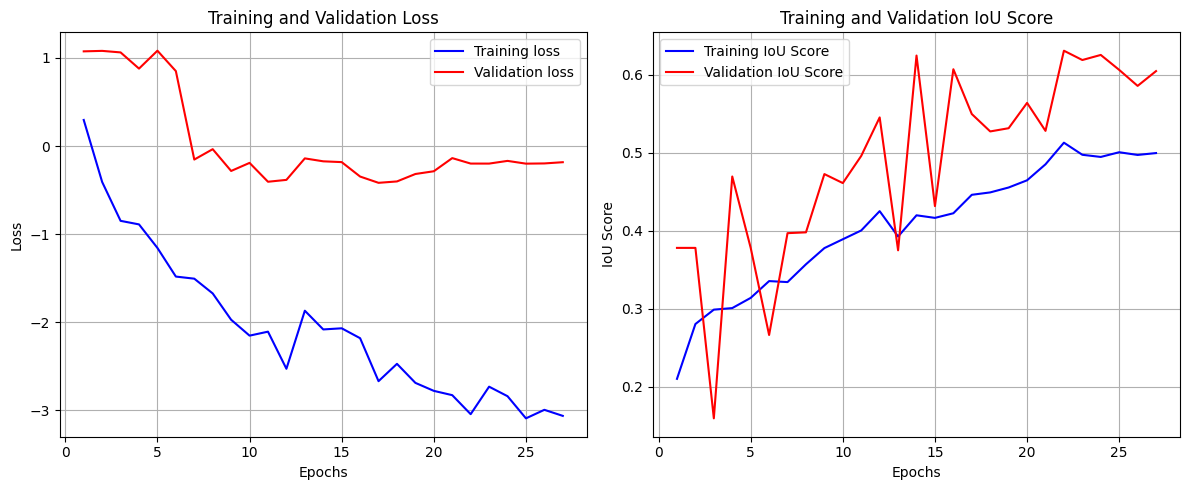

In [18]:
import matplotlib.pyplot as plt

# --- Get the training history ---
history_dict = history.history

# --- Plot Loss ---
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot IoU Score ---
iou = history_dict['iou_score']
val_iou = history_dict['val_iou_score']

plt.subplot(1, 2, 2)
plt.plot(epochs, iou, 'b-', label='Training IoU Score')
plt.plot(epochs, val_iou, 'r-', label='Validation IoU Score')
plt.title('Training and Validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Step 8: Evaluate on the Test Set
The ultimate test of a model is its performance on completely unseen data. We will now load the best weights we saved during training (from the .keras file) and evaluate the model's performance on the X_test and Y_test datasets.

In [19]:
from sklearn.metrics import classification_report

# --- Load the best saved model weights ---
# Note: Since we used restore_best_weights=True, the model in memory is already the best one.
# This is just to demonstrate how to load it from the file for future use.
unetplusplus_resnet101_model.load_weights(model_weights_path)
print(f"Loaded best model weights from {model_weights_path}")

# --- Evaluate the model on the test data ---
print("\n--- Evaluating model on the test set ---")
# --- CHANGE HERE: Use the preprocessed test data for evaluation ---
results = unetplusplus_resnet101_model.evaluate(X_test_preprocessed, Y_test_cat, batch_size=BATCH_SIZE)
print(f"Test Loss: {results[0]}")
print(f"Test IoU Score: {results[1]}")
print(f"Test F1-Score: {results[2]}")

# --- Generate Classification Report ---
# To do this, we need to get predictions for the test set
print("\n--- Generating Classification Report ---")
# --- CHANGE HERE: Use the preprocessed test data for prediction ---
y_pred = unetplusplus_resnet101_model.predict(X_test_preprocessed)
y_pred_argmax = np.argmax(y_pred, axis=3)

# We need to flatten the arrays to compare them
y_test_flat = Y_test.flatten()
y_pred_flat = y_pred_argmax.flatten()

# Define class names (assuming 0: background, 1-3: weed types)
class_names = ['Background', 'Weed Type 1', 'Weed Type 2', 'Weed Type 3']

print(classification_report(y_test_flat, y_pred_flat, target_names=class_names))

Loaded best model weights from unetplusplus_resnet101_best_model.weights.h5

--- Evaluating model on the test set ---
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - f1-score: 0.5851 - iou_score: 0.4926 - loss: -1.3043

E0000 00:00:1754985031.596979      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754985031.843278      90 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 560ms/step - f1-score: 0.5850 - iou_score: 0.4919 - loss: -1.3280
Test Loss: -1.5540741682052612
Test IoU Score: 0.4856950640678406
Test F1-Score: 0.5848330855369568

--- Generating Classification Report ---
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step

E0000 00:00:1754985081.901884      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754985082.157062      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754985083.990676      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754985084.296609      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step 
              precision    recall  f1-score   support

  Background       0.91      0.85      0.88   8360540
 Weed Type 1       0.67      0.70      0.69    331575
 Weed Type 2       0.28      0.36      0.31     84337
 Weed Type 3       0.46      0.61      0.52   1578236

    accuracy                           0.81  10354688
   macro avg       0.58      0.63      0.60  10354688
weighted avg       0.83      0.81      0.82  10354688



## Step 9: Visual Inference on Test Images
Finally, let's look at some actual predictions. We'll pick a few random images from our test set and compare the original image, the ground truth mask provided by the dataset, and the segmentation mask predicted by our trained model. This gives us a qualitative understanding of where the model is performing well and where it might be making mistakes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


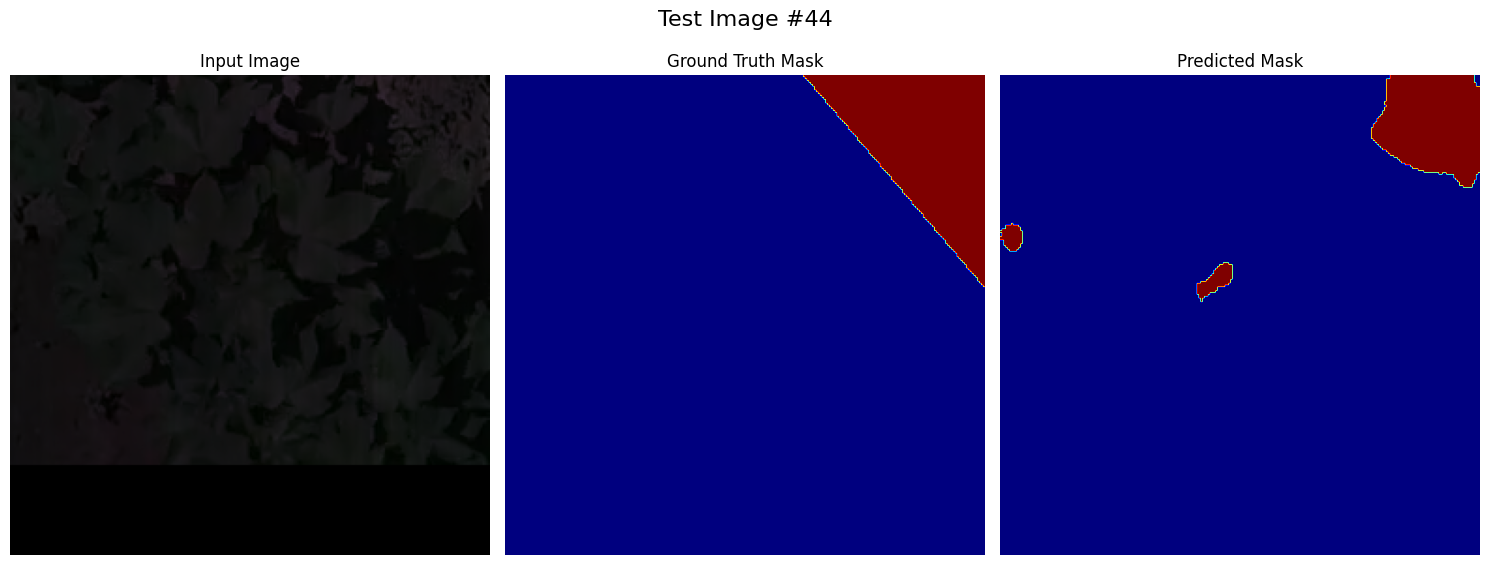

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


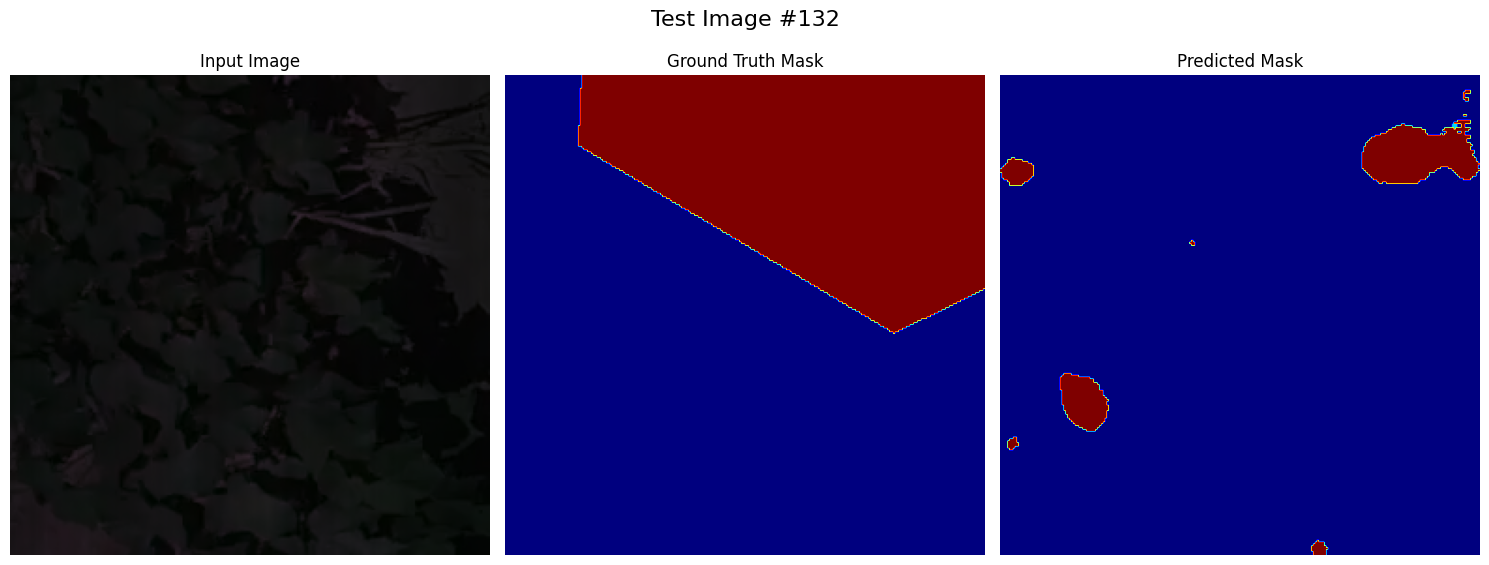

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


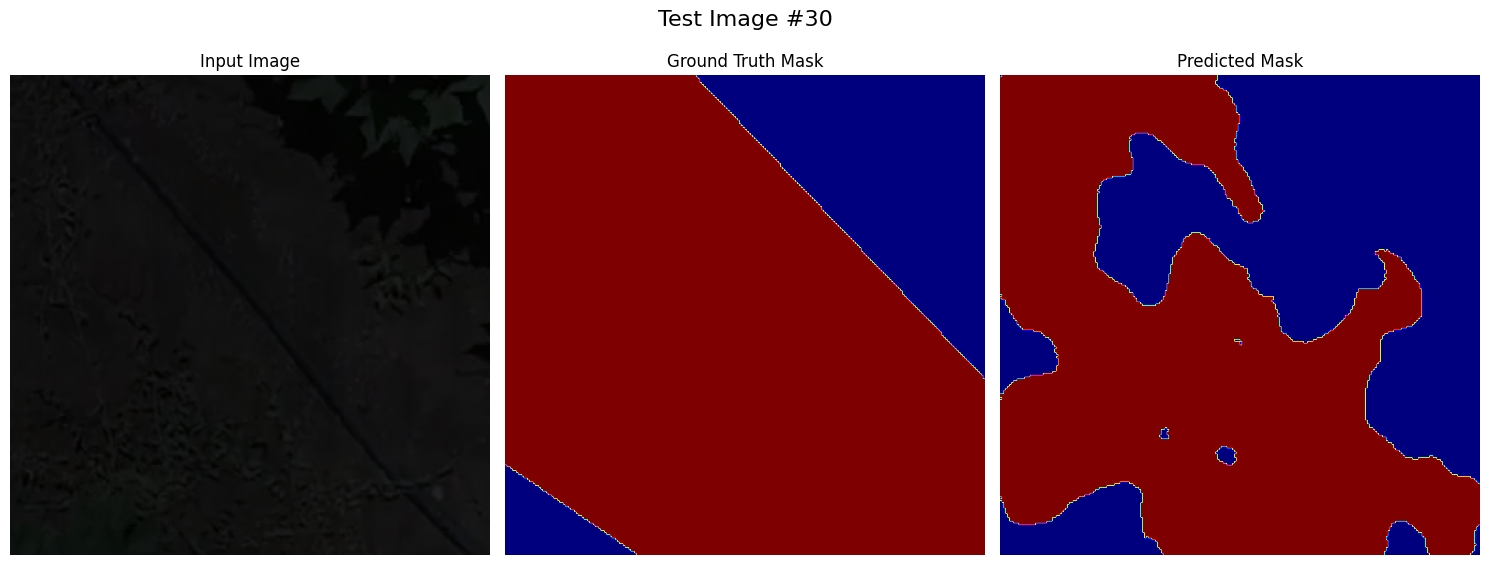

In [20]:
import random

# --- Select a few random images from the test set ---
num_images_to_show = 3
test_indices = [random.randint(0, len(X_test) - 1) for _ in range(num_images_to_show)]

for i, index in enumerate(test_indices):
    # Get the ORIGINAL image for display purposes
    test_img = X_test[index]
    
    # Get the ground truth mask
    ground_truth = Y_test[index]
    
    # --- CHANGE HERE: Get the corresponding PREPROCESSED image for the model ---
    test_img_preprocessed = X_test_preprocessed[index]
    
    # Expand dims to add the batch dimension for prediction
    test_img_input = np.expand_dims(test_img_preprocessed, 0)
    
    # Make the prediction using the preprocessed image
    prediction = unetplusplus_resnet101_model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(15, 6))
    plt.suptitle(f'Test Image #{index}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(test_img) # Display the original image
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(ground_truth, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(predicted_img, cmap='jet')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Step 10: Calculating Mean IoU and Mean Precision
While Mean Average Precision (mAP) is the primary metric for object detection tasks, the direct and standard equivalent for semantic segmentation is Mean Intersection over Union (mIoU).

In [21]:
import tensorflow as tf
import numpy as np

# This cell requires the variables 'y_pred_argmax' and 'Y_test' 
# from the evaluation cell (Cell 19) to be available.

# --- 1. Calculate Mean IoU (mIoU) ---
print("--- Calculating Mean IoU (mIoU) and Class-wise IoU ---")

# Instantiate the Keras MeanIoU metric
# Use the 'n_classes' variable from our data preparation step
iou_metric = tf.keras.metrics.MeanIoU(num_classes=n_classes)

# Update the metric's state with the ground truth and predictions
# Note: We use Y_test (integer labels) and y_pred_argmax (integer labels), 
# NOT the one-hot encoded categorical versions.
iou_metric.update_state(Y_test, y_pred_argmax)

# Get the final Mean IoU result.
mean_iou = iou_metric.result().numpy()

print(f"\nMean Intersection over Union (mIoU): {mean_iou:.4f}")
print("This is the primary metric for evaluating a semantic segmentation model.")


# --- 2. Calculate and Display Class-wise IoU ---
print("\n--- IoU Scores for Each Class ---")
# ### FIX: Access the confusion matrix directly from the 'total_cm' variable ###
confusion_matrix = iou_metric.total_cm.numpy()

# Calculate IoU for each class
# The rest of this logic remains the same
for i in range(n_classes):
    # True Positives are on the diagonal
    true_positives = confusion_matrix[i, i]
    # False Positives are the sum of the column, excluding the diagonal
    false_positives = np.sum(confusion_matrix[:, i]) - true_positives
    # False Negatives are the sum of the row, excluding the diagonal
    false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
    
    # Calculate IoU
    denominator = true_positives + false_positives + false_negatives
    iou = true_positives / (denominator + 1e-6) # Add epsilon to avoid division by zero
    
    # Use the class_names defined in Cell 19
    print(f"Class '{class_names[i]}': IoU = {iou:.4f}")

    
# --- 3. Extract Mean Precision from Classification Report ---
# This part was already correct and requires no changes.
report = classification_report(y_test_flat, y_pred_flat, output_dict=True)
mean_precision = report['macro avg']['precision']

print(f"\nMean Average Precision (Macro Avg): {mean_precision:.4f}")
print("This is the unweighted average of the precision scores for each class.")

--- Calculating Mean IoU (mIoU) and Class-wise IoU ---

Mean Intersection over Union (mIoU): 0.4626
This is the primary metric for evaluating a semantic segmentation model.

--- IoU Scores for Each Class ---
Class 'Background': IoU = 0.7872
Class 'Weed Type 1': IoU = 0.5226
Class 'Weed Type 2': IoU = 0.1858
Class 'Weed Type 3': IoU = 0.3548

Mean Average Precision (Macro Avg): 0.5808
This is the unweighted average of the precision scores for each class.


In [23]:
from IPython.display import FileLink
FileLink('unetplusplus_resnet101_best_model.weights.h5')

/kaggle/working/unetplusplus_resnet101_best_model.weights.h5

In [22]:
!ls -lh unetplusplus_resnet101_best_model.weights.h5

-rw-r--r-- 1 root root 764M Aug 12 07:21 unetplusplus_resnet101_best_model.weights.h5
